In [1]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

import glob, json
import os

In [ ]:
!git clone https://github.com/ggonzalesd/owo-encoder git_project

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [7]:
class AnimeDataset(Dataset):
  def __init__(self, path, transform):
    super(AnimeDataset, self).__init__()
    self.path = path
    self.transform = transform
    self.images = glob.glob(os.path.join(self.path, '*'))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    X = self.transform(Image.open(self.images[index]))
    return X

  def __repr__(self):
    return f"<AnimeDataset len:{len(self.images)}>"

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(0.0, 1.0)
])

dataset = AnimeDataset('./git_project/images', transform)

In [8]:
train_dl = DataLoader(dataset, 32, shuffle=True)

X_batch = next(iter(train_dl))

In [9]:
class ConvBlock(nn.Module):
  def __init__(self, ch_in, ch_out):
    super(ConvBlock, self).__init__()
    self.block = nn.Sequential(
      nn.Conv2d(ch_in, ch_out, 3, 2, 1, bias=False),
      nn.BatchNorm2d(ch_out),
      nn.LeakyReLU(0.02)
    )
  def forward(self, X):
    return self.block(X)

In [10]:
class ConvTBlock(nn.Module):
  def __init__(self, ch_in, ch_out, dropout = True, sigmoid=False):
    super(ConvTBlock, self).__init__()
    self.block = nn.Sequential(
      nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, output_padding=1),
      nn.Dropout2d(0.25) if dropout else nn.Identity(),
      nn.Sigmoid() if sigmoid else nn.ReLU()
    )
  def forward(self, X):
    return self.block(X)

In [182]:
class OwoEncoder(nn.Module):
  def __init__(self):
    super(OwoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      ConvBlock(3, 32),
      ConvBlock(32, 64),
      ConvBlock(64, 128),
      ConvBlock(128, 256),
      ConvBlock(256, 512),
      nn.Conv2d(512, 1028, 2),
      nn.LeakyReLU(0.02)
    )
    self.linear_std = nn.Linear(1028, 32)
    self.linear_mean = nn.Linear(1028, 32)
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(32, 512, 2),
      nn.ReLU(),
      ConvTBlock(512, 256),
      ConvTBlock(256, 128),
      ConvTBlock(128, 64),
      ConvTBlock(64, 32),
      ConvTBlock(32, 3, False, True),
    )

  def forward(self, X):
    features = torch.flatten(self.encoder(X), start_dim=1, end_dim=-1)
    mean = self.linear_mean(features)
    std = self.linear_std(features)
    norm = torch.randn_like(std)*std + mean
    z = norm.unsqueeze(-1).unsqueeze(-1)
    fake = self.decoder(z)
    return fake, mean, std

model = OwoEncoder().to(device)
fake, mean, std = model(X_batch.to(device))
fake.shape, mean.shape, std.shape

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-8)
bce_loss_fn = nn.BCELoss()
kl_loss_fn = lambda mean, std: (-0.5*(1 + torch.log(std**2) - mean**2 - std**2).sum(1)).mean()

In [ ]:
model = model.to(device)
for i in range(60):
  train_loss = .0
  for X_batch in tqdm(train_dl):
    X_batch = X_batch.to(device)
    model.train()
    fake, mean, std = model(X_batch)

    bce_loss = bce_loss_fn(fake, X_batch)
    kl_loss = kl_loss_fn(mean, std) * 0.0001

    loss = bce_loss + kl_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * X_batch.shape[0]

  train_loss /= len(train_dl.dataset)

  print(train_loss)

In [184]:
train_loss

0.5771033918387766

In [185]:
X_batch.shape

torch.Size([17, 3, 64, 64])

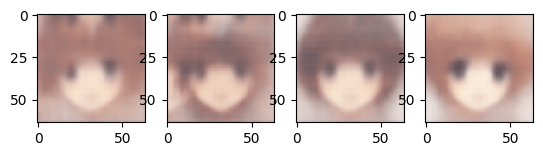

In [195]:
model.eval()
z = model.decoder(torch.randn(4, 32, 1, 1).to(device))
z = z.detach().cpu().moveaxis(1, -1).numpy()
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(z[i])
plt.show()

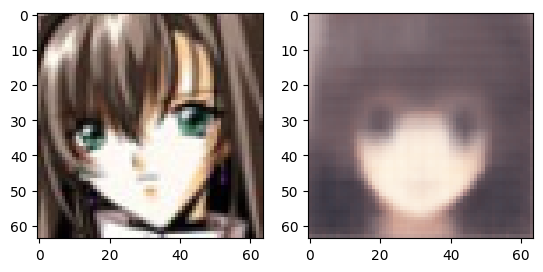

In [198]:
X_batch = next(iter(train_dl))

model.eval()
fake, mean, std = model(X_batch[:1,:,:,:].to(device))

plt.subplot(1, 2, 1)
plt.imshow(X_batch[0].moveaxis(0, 2).numpy())
plt.subplot(1, 2, 2)
plt.imshow(fake.detach().cpu()[0].moveaxis(0, 2).numpy())

In [191]:
mean

tensor([[-0.8851,  0.1248, -5.3375, -0.7972,  0.4914, -0.2790,  0.4002,  0.1224,
          0.9637, -2.3261, -0.8843, -0.8348,  0.0286,  1.2399, -3.8085, -0.4201,
         -0.6100,  0.7251,  0.4385, -0.1611,  1.0453,  0.2801,  0.5694, -2.4850,
          0.4119, -0.8446,  0.3277, -0.4766,  0.2516,  0.3959,  0.7637,  0.3622]],
       device='cuda:0', grad_fn=<AddmmBackward0>)